# Modeling

The end of the line, this section is comprised of the pre-processing stage, which entails additional feature selection and then encoding for modeling. The next stage is modeling, in which I will select a model that I think is the best for the the data.

Let's get started!

## Pre-processing

In [6]:
# start with imports
import wrangle as w
import explore as e

# library imports
import pandas as pd
import numpy as np

ranstate = 42

In [7]:
# import the data
train,validate,test = w.wrangle_iot2022()

Reading from file...


In [8]:
train.shape

(86181, 84)

### Encoding

The first thing I need to encode the data. Since I will be primarily using SciKitLearn, the algorithms all require the data to be numerically encoded. For this, i will likely also be relying on some pre-built functions.

In [11]:
def encode_df(dframe,target):
	'''
	Takes a processed dataframe and encodes the object columns for usage in modeling.
		Takes a dataframe and a target variable (assuming the target variable is an object). Target variable keeps the thing the model is being trained on from splitting and altering it.
		!!! MAKE ME MORE DYNAMIC !!!
	- Add functionality to check if passed a list or dataframe
	- If dataframe, then run standard loop
	- If list then check if each item is a dataframe (checking for train/validate/test)
	- If list and each item is dataframe, then try loop on each dataframe
	- Otherwise return an error
	'''
	df = dframe.copy()
	# Get the object columns from the dataframe
	obj_col = [col for col in df.columns if df[col].dtype == 'O']
		# remove target variable
	obj_col.remove(target)
		# Begin encoding the object columns
	for col in obj_col:
		# Grab current column dummies
		dummies = pd.get_dummies(df[col],drop_first=True)
				# concatenate the names in a descriptive manner
		dummies.columns = [col+'_is_'+column for column in dummies.columns]
		# add these new columns to the dataframe
		for column in dummies.columns:
			df[column] = dummies[column].astype(float)
				# Drop the old columns from the dataframe
		df = df.drop(columns=col)
	return df 

In [12]:
# Encode all of the dataframes simultaneously
encoded = [encode_df(df,"Attack_type") for df in [train,validate,test]]

In [13]:
[print(df.shape) for df in encoded]

(86181, 93)
(25855, 92)
(11081, 92)


[None, None, None]

Well that's unusual. Why are validate and test missing a column?

In [15]:
[print(df.shape) for df in [train,validate,test]]

(86181, 84)
(25855, 84)
(11081, 84)


[None, None, None]

I can see that I'm losing a column during the encoding process.

In [17]:
encoded[1].columns

Index(['id.orig_p', 'id.resp_p', 'flow_duration', 'fwd_pkts_tot',
       'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot',
       'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec',
       'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min',
       'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'flow_CWR_flag_count',
       'flow_ECE_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std',
       'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 

In [18]:
set(encoded[0].columns).symmetric_difference(set(encoded[1].columns))

{'service_is_radius'}

In [19]:
set(encoded[0].columns).symmetric_difference(set(encoded[2].columns))

{'service_is_radius'}

So in both, the 'service_is_radius' column is missing.

What I'm going to do is adjust the function so that no columns are dropped and see what I get from that.

In [21]:
def encode_df(dframe,target):
	'''
	Takes a processed dataframe and encodes the object columns for usage in modeling.
		Takes a dataframe and a target variable (assuming the target variable is an object). Target variable keeps the thing the model is being trained on from splitting and altering it.
		!!! MAKE ME MORE DYNAMIC !!!
	- Add functionality to check if passed a list or dataframe
	- If dataframe, then run standard loop
	- If list then check if each item is a dataframe (checking for train/validate/test)
	- If list and each item is dataframe, then try loop on each dataframe
	- Otherwise return an error
	'''
	df = dframe.copy()
	# Get the object columns from the dataframe
	obj_col = [col for col in df.columns if df[col].dtype == 'O']
		# remove target variable
	obj_col.remove(target)
		# Begin encoding the object columns
	for col in obj_col:
		# Grab current column dummies
		dummies = pd.get_dummies(df[col])
				# concatenate the names in a descriptive manner
		dummies.columns = [col+'_is_'+column for column in dummies.columns]
		# add these new columns to the dataframe
		for column in dummies.columns:
			df[column] = dummies[column].astype(float)
				# Drop the old columns from the dataframe
		df = df.drop(columns=col)
	return df 

In [22]:
encoded = [encode_df(df.drop(['traffic_type'],axis=1),"Attack_type") for df in [train,validate,test]]

In [23]:
[print(df.shape) for df in encoded]

(86181, 94)
(25855, 93)
(11081, 93)


[None, None, None]

Well that did nothing.

~I'll just build a function then that gets the columns, and if any are missing a column to isolate that column and add it, filling the values with 0.~

I will *not* do that, and instead I will *drop* the columns that are different!

In [25]:
set(encoded[0].columns).symmetric_difference(set(encoded[1].columns))

{'service_is_radius'}

In [26]:
set(encoded[0].columns).symmetric_difference(set(encoded[2].columns))

{'service_is_radius'}

In [27]:
encoded[0] = encoded[0].drop(['service_is_radius'],axis=1)

In [28]:
[print(df.shape) for df in encoded]

(86181, 93)
(25855, 93)
(11081, 93)


[None, None, None]

The next thing I want to do is to do an analysis on these. I'm going to revert to a graph I made back in wrangle for this.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

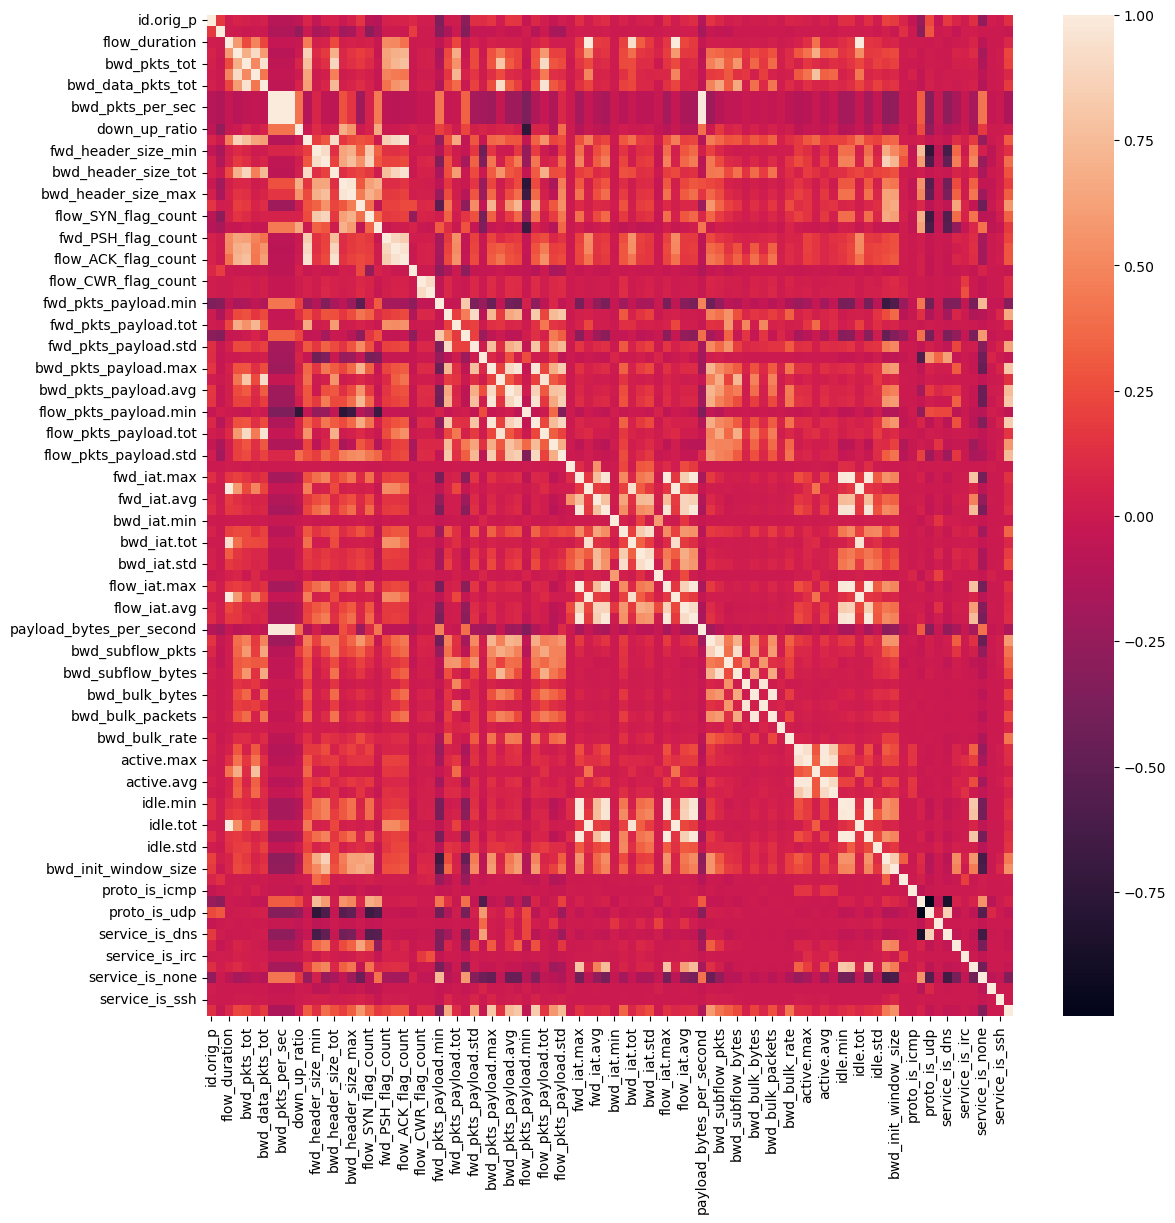

In [31]:
plt.figure(figsize=(13,13))
sns.heatmap(
    encoded[0].drop(["Attack_type"],axis=1).corr()
)
plt.show()

### Isolate features and target variable

At this point, I'm getting where I need to keep the features and target variable separate.

In [34]:
X_set = [df.drop("Attack_type",axis=1) for df in encoded]

In [35]:
[print(df.shape) for df in X_set]

(86181, 92)
(25855, 92)
(11081, 92)


[None, None, None]

In [36]:
y_set = [df["Attack_type"] for df in encoded]

In [37]:
[print(df.shape) for df in y_set]

(86181,)
(25855,)
(11081,)


[None, None, None]

### PCA

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(random_state=ranstate)

In [41]:
pd.DataFrame(pca.fit_transform(X_set[0],y_set[0]),columns=pca.get_feature_names_out())

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca82,pca83,pca84,pca85,pca86,pca87,pca88,pca89,pca90,pca91
0,-5.954315e+06,1.105558e+07,-2.479314e+06,4.626833e+06,255673.333964,71607.747637,-63221.836720,-137964.370670,23605.602297,32050.461402,...,-0.001381,0.000201,0.000218,-0.000019,0.000016,6.752264e-06,0.000007,2.944637e-06,1.291634e-07,9.646254e-09
1,-5.965773e+06,9.217068e+06,-2.350419e+06,4.457896e+06,247691.669229,69405.170582,-61286.155713,-133738.972384,22881.626311,31065.848754,...,-0.000350,0.000749,0.000652,-0.000136,0.000044,-2.544955e-06,0.000001,2.973378e-06,-1.870201e-08,1.419728e-06
2,-5.770989e+06,4.047179e+07,-4.541622e+06,7.329784e+06,383377.540570,106834.280039,-94217.285711,-205529.025777,35148.206714,47709.766504,...,-0.000838,-0.003030,-0.002288,0.000289,0.000187,2.481353e-05,-0.000002,1.780198e-08,2.662274e-10,2.452063e-08
3,-5.954315e+06,1.105558e+07,-2.479313e+06,4.626832e+06,255672.906441,71607.178725,-63222.376706,-137962.490215,23604.075533,32047.051575,...,-0.000742,0.000559,0.000502,-0.000095,0.000035,8.803400e-07,0.000004,2.973621e-06,4.069938e-06,-1.131414e-07
4,-5.770989e+06,4.047179e+07,-4.541621e+06,7.329783e+06,383377.285633,106833.876931,-94217.662124,-205527.817976,35147.338801,47707.580356,...,-0.005160,-0.000953,0.002110,-0.002078,-0.000344,-1.970816e-04,0.000051,-7.697375e-08,-1.210439e-07,-2.644030e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86176,-5.919395e+06,1.665867e+07,-2.872133e+06,5.141681e+06,279996.202414,78317.760193,-69123.219926,-150832.972101,25805.064282,35035.767573,...,-0.001624,0.000156,0.000187,-0.000007,0.000014,8.430530e-06,0.000007,3.100021e-06,-1.214531e-10,-1.050292e-10
86177,-6.117273e+06,-1.509216e+07,-6.461545e+05,2.224210e+06,142164.314152,40295.001391,-35678.009044,-77910.810540,13343.684292,18124.968860,...,-0.001232,-0.000138,-0.000077,0.000042,-0.000004,7.962963e-06,0.000005,2.360757e-06,-7.885078e-11,-3.348288e-10
86178,-5.895649e+06,2.046877e+07,-3.139250e+06,5.491776e+06,296535.083665,82880.122865,-73136.172547,-159581.880797,27299.562471,37063.351333,...,-0.001319,0.000388,0.000375,-0.000055,0.000027,5.254922e-06,0.000006,3.186895e-06,-8.444413e-11,-9.807834e-10
86179,-6.010724e+06,2.004439e+06,-1.844759e+06,3.795156e+06,216382.067541,60768.714734,-53687.835259,-117176.838435,20053.327278,27229.828135,...,-0.001294,0.000104,0.000132,-0.000002,0.000010,6.841887e-06,0.000006,-5.497736e-05,1.650702e-11,-1.959189e-10


In [42]:
def pca_transform(X,y,ranstate=42):
    """
    Return 
    
    Parameters:
    -----------
    - X: DataFrame
        Data to be transformed
    - y: Series
        Target variable
    - ranstate: Int (Optional)
        Default = 42
    
    Returns:
    --------
    
    """
    
    # build the selector
    pca = PCA(random_state=ranstate)
    
    # export as dataframe
    df = pd.DataFrame(pca.fit_transform(X,y),columns=pca.get_feature_names_out())
    
    return df
    

In [43]:
pca_transform(X_set[0],y_set[0])

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca82,pca83,pca84,pca85,pca86,pca87,pca88,pca89,pca90,pca91
0,-5.954315e+06,1.105558e+07,-2.479314e+06,4.626833e+06,255673.333964,71607.747637,-63221.836720,-137964.370670,23605.602297,32050.461402,...,-0.001381,0.000201,0.000218,-0.000019,0.000016,6.752264e-06,0.000007,2.944637e-06,1.291634e-07,9.646254e-09
1,-5.965773e+06,9.217068e+06,-2.350419e+06,4.457896e+06,247691.669229,69405.170582,-61286.155713,-133738.972384,22881.626311,31065.848754,...,-0.000350,0.000749,0.000652,-0.000136,0.000044,-2.544955e-06,0.000001,2.973378e-06,-1.870201e-08,1.419728e-06
2,-5.770989e+06,4.047179e+07,-4.541622e+06,7.329784e+06,383377.540570,106834.280039,-94217.285711,-205529.025777,35148.206714,47709.766504,...,-0.000838,-0.003030,-0.002288,0.000289,0.000187,2.481353e-05,-0.000002,1.780198e-08,2.662274e-10,2.452063e-08
3,-5.954315e+06,1.105558e+07,-2.479313e+06,4.626832e+06,255672.906441,71607.178725,-63222.376706,-137962.490215,23604.075533,32047.051575,...,-0.000742,0.000559,0.000502,-0.000095,0.000035,8.803400e-07,0.000004,2.973621e-06,4.069938e-06,-1.131414e-07
4,-5.770989e+06,4.047179e+07,-4.541621e+06,7.329783e+06,383377.285633,106833.876931,-94217.662124,-205527.817976,35147.338801,47707.580356,...,-0.005160,-0.000953,0.002110,-0.002078,-0.000344,-1.970816e-04,0.000051,-7.697375e-08,-1.210439e-07,-2.644030e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86176,-5.919395e+06,1.665867e+07,-2.872133e+06,5.141681e+06,279996.202414,78317.760193,-69123.219926,-150832.972101,25805.064282,35035.767573,...,-0.001624,0.000156,0.000187,-0.000007,0.000014,8.430530e-06,0.000007,3.100021e-06,-1.214531e-10,-1.050292e-10
86177,-6.117273e+06,-1.509216e+07,-6.461545e+05,2.224210e+06,142164.314152,40295.001391,-35678.009044,-77910.810540,13343.684292,18124.968860,...,-0.001232,-0.000138,-0.000077,0.000042,-0.000004,7.962963e-06,0.000005,2.360757e-06,-7.885078e-11,-3.348288e-10
86178,-5.895649e+06,2.046877e+07,-3.139250e+06,5.491776e+06,296535.083665,82880.122865,-73136.172547,-159581.880797,27299.562471,37063.351333,...,-0.001319,0.000388,0.000375,-0.000055,0.000027,5.254922e-06,0.000006,3.186895e-06,-8.444413e-11,-9.807834e-10
86179,-6.010724e+06,2.004439e+06,-1.844759e+06,3.795156e+06,216382.067541,60768.714734,-53687.835259,-117176.838435,20053.327278,27229.828135,...,-0.001294,0.000104,0.000132,-0.000002,0.000010,6.841887e-06,0.000006,-5.497736e-05,1.650702e-11,-1.959189e-10


### SelectKBest

In [45]:
from sklearn import feature_selection as fselect

In [46]:
kbest = fselect.SelectKBest(k=50)

In [47]:
kbest.fit(X_set[0],y_set[0])

SelectKBest(k=50)

In [48]:
kbest.get_feature_names_out()

array(['id.orig_p', 'id.resp_p', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_min',
       'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_URG_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std',
       'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.max', 'flow_pkts_payload.avg',
       'flow_pkts_payload.std', 'fwd_iat.max', 'fwd_iat.avg',
       'fwd_iat.std', 'flow_iat.max', 'flow_iat.avg', 'flow_iat.std',
       'payload_bytes_per_second', 'fwd_subflow_pkts', 'bwd_subflow_pkts',
       'active.min', 'idle.min', 'idle.max', 'idle.avg',
       'fwd_init_window_size', 'bwd_init_window_size',
       'fwd_last_window_size', 'proto_is_tcp', 'proto_is_udp',
       'service_is_

In [49]:
kbest.transform(X_set[0])

array([[7.81800000e+03, 2.10000000e+01, 2.46723765e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.82400000e+04, 2.10000000e+01, 2.62144000e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.53410000e+04, 2.10000000e+01, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.51800000e+03, 2.10000000e+01, 1.67772160e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.10600000e+03, 2.10000000e+01, 3.22638769e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.49990000e+04, 2.10000000e+01, 1.04857600e+06, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [50]:
# Get the most important features
pd.DataFrame(data=kbest.scores_,index=X_set[0].columns).sort_values(by=0,ascending=False)

,0
fwd_URG_flag_count,5.413222e+06
service_is_mqtt,2.433259e+06
service_is_none,1.436653e+05
fwd_pkts_payload.min,1.036721e+05
fwd_last_window_size,3.913950e+04
...,...
service_is_dhcp,2.924209e+01
fwd_bulk_packets,2.202968e+01
fwd_bulk_rate,1.623044e+01
fwd_bulk_bytes,8.919058e+00


In [51]:
# Return the transformed dataset
kbest_train = pd.DataFrame(data=kbest.transform(X_set[0]),columns=kbest.get_feature_names_out())

In [52]:
def kbest(X,y):
    """
    Returns a dataframe containing the top 50 KBest features.
    
    Parameters:
    -----------
    - X: DataFrame
        The data to be trained on
    - y: Series
        The target variable
    
    Returns:
    --------
    - kbest: DataFrame
        The transformed dataset
    
    """
    
    # Build the model
    kbest = fselect.SelectKBest(k=50)
    
    # fit and transform the model
    df_kbest = pd.DataFrame(data=kbest.fit_transform(X,y),columns=kbest.get_feature_names_out())
    
    return df_kbest

In [53]:
kbest(X_set[0],y_set[0])

,id.orig_p,id.resp_p,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_min,fwd_header_size_max,bwd_header_size_min,bwd_header_size_max,...,fwd_last_window_size,proto_is_tcp,proto_is_udp,service_is_dns,service_is_http,service_is_irc,service_is_mqtt,service_is_none,service_is_ssh,service_is_ssl
0,7818.0,21.0,2.467238e+05,2.467238e+05,4.934475e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,28240.0,21.0,2.621440e+05,2.621440e+05,5.242880e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,25341.0,21.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,20.0,20.0,0.0,0.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,20526.0,21.0,2.467238e+05,2.467238e+05,4.934475e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,33928.0,137.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.0,8.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86176,3269.0,21.0,1.997288e+05,1.997288e+05,3.994575e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86177,9479.0,21.0,4.660338e+05,4.660338e+05,9.320676e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86178,9518.0,21.0,1.677722e+05,1.677722e+05,3.355443e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86179,9106.0,21.0,3.226388e+05,3.226388e+05,6.452775e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### In-class brain-picking

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
lr = LogisticRegression(class_weight='balanced')

In [57]:
lr.fit(X_set[0],y_set[0])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [58]:
lr.score(X_set[0],y_set[0])

0.7553289008018008

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
pd.DataFrame(confusion_matrix(y_set[0],lr.predict(X_set[0])))

,0,1,2,3,4,5,6,7,8,9,10,11
0,565,43,1282,180,1014,0,0,61,1665,0,153,462
1,18,191,144,1,16,0,0,0,3,0,0,1
2,0,0,58647,0,0,0,0,46,7568,0,0,0
3,1,1,0,2754,76,0,0,0,6,0,29,35
4,0,0,2,0,21,0,0,0,2,0,0,1
5,0,0,1,0,1,0,0,0,17,0,1,0
6,0,0,0,0,0,0,0,1400,0,0,0,0
7,0,0,2,0,3,0,0,696,0,0,0,0
8,1,0,97,0,10,0,0,1,1700,0,1,3
9,0,0,0,0,1,0,0,1397,8,0,1,0


In [61]:
lr.score(X_set[1][X_set[0].columns],y_set[1])

0.754476890350029

In [62]:
from sklearn.metrics import classification_report

In [63]:
print(classification_report(y_set[1],lr.predict(X_set[1][X_set[0].columns])))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.93      0.10      0.18      1627
            DDOS_Slowloris       0.80      0.51      0.62       112
             DOS_SYN_Hping       0.97      0.89      0.93     19878
              MQTT_Publish       0.94      0.94      0.94       871
Metasploit_Brute_Force_SSH       0.01      0.88      0.01         8
             NMAP_FIN_SCAN       0.00      0.00      0.00         6
         NMAP_OS_DETECTION       0.00      0.00      0.00       420
             NMAP_TCP_scan       0.19      1.00      0.33       211
             NMAP_UDP_SCAN       0.15      0.93      0.26       544
       NMAP_XMAS_TREE_SCAN       0.00      0.00      0.00       422
               Thing_Speak       0.63      0.06      0.11      1703
                Wipro_bulb       0.03      0.51      0.06        53

                  accuracy                           0.75     25855
                 macro avg       0.39      0.4

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
print(classification_report(y_set[0],lr.predict(X_set[0][X_set[0].columns])))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.90      0.10      0.19      5425
            DDOS_Slowloris       0.77      0.51      0.62       374
             DOS_SYN_Hping       0.97      0.89      0.93     66261
              MQTT_Publish       0.93      0.95      0.94      2902
Metasploit_Brute_Force_SSH       0.01      0.81      0.01        26
             NMAP_FIN_SCAN       0.00      0.00      0.00        20
         NMAP_OS_DETECTION       0.00      0.00      0.00      1400
             NMAP_TCP_scan       0.19      0.99      0.32       701
             NMAP_UDP_SCAN       0.15      0.94      0.26      1813
       NMAP_XMAS_TREE_SCAN       0.00      0.00      0.00      1407
               Thing_Speak       0.69      0.07      0.13      5675
                Wipro_bulb       0.04      0.64      0.07       177

                  accuracy                           0.76     86181
                 macro avg       0.39      0.4

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
from sklearn import metrics

In [66]:
metrics.roc_auc_score(y_set[1], lr.predict_proba(X_set[1][X_set[0].columns]), multi_class='ovr',average='weighted')

0.9821220747944409

In [67]:
metrics.roc_auc_score(y_set[1], lr.predict_proba(X_set[1][X_set[0].columns]), multi_class='ovo')

0.9207961641559734

In [68]:
metrics.roc_auc_score(y_set[1], lr.predict_proba(X_set[1][X_set[0].columns]), multi_class='ovo',average='weighted')

0.968056106869399

In [69]:
lr2 = LogisticRegression(max_iter=1000,class_weight='balanced')

In [70]:
lr2.fit(kbest_train,y_set[0])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [71]:
metrics.roc_auc_score(y_set[0], lr2.predict_proba(kbest_train), multi_class='ovo',average='weighted')

0.9821552624929321

In [72]:
print(classification_report(y_set[0],lr2.predict(kbest_train)))

                            precision    recall  f1-score   support

            ARP_poisioning       0.66      0.48      0.55      5425
            DDOS_Slowloris       0.39      0.96      0.56       374
             DOS_SYN_Hping       1.00      0.88      0.94     66261
              MQTT_Publish       0.98      0.97      0.97      2902
Metasploit_Brute_Force_SSH       0.10      0.77      0.17        26
             NMAP_FIN_SCAN       0.00      0.85      0.00        20
         NMAP_OS_DETECTION       0.54      0.73      0.62      1400
             NMAP_TCP_scan       0.99      0.99      0.99       701
             NMAP_UDP_SCAN       0.61      0.69      0.65      1813
       NMAP_XMAS_TREE_SCAN       0.58      0.36      0.44      1407
               Thing_Speak       0.89      0.46      0.60      5675
                Wipro_bulb       0.34      0.67      0.45       177

                  accuracy                           0.82     86181
                 macro avg       0.59      0.7

### Pipeline building

In [74]:
from sklearn.pipeline import Pipeline

In [75]:
pca_pipe = Pipeline(
    [('pca',PCA(random_state=42)),('lr',LogisticRegression(class_weight='balanced'))]
)
pca_pipe

Pipeline(steps=[('pca', PCA(random_state=42)),
                ('lr', LogisticRegression(class_weight='balanced'))])

In [76]:
pca_pipe.fit(X_set[0],y_set[0]).score(X_set[1],y_set[1])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7661574163604719

In [77]:
kbest_pipe = Pipeline(
    [('kbest',fselect.SelectKBest(k=50)),('lr',LogisticRegression(class_weight='balanced'))]
)
kbest_pipe

Pipeline(steps=[('kbest', SelectKBest(k=50)),
                ('lr', LogisticRegression(class_weight='balanced'))])

In [78]:
kbest_pipe.fit(X_set[0],y_set[0]).score(X_set[1],y_set[1])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8175207890156643

In [79]:
pipe_test = Pipeline([('kbest',fselect.SelectKBest(k=50)),('clf',LogisticRegression())])

In [80]:
pipe_test.fit(X_set[0],y_set[0]).score(X_set[1],y_set[1])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7903693676271514

### GridSearch testing

In [174]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,RobustScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [214]:
search_space = [
    {'clf':[LogisticRegression(class_weight='balanced',random_state=42,max_iter=1000,solver='saga')],
        'clf__C':[1.0, 0.1, 0.01, 0.001]},
    {'clf':[DecisionTreeClassifier(class_weight='balanced',random_state=42)],
        'clf__max_depth':[3,6,9,12,15]},
    {'clf':[RandomForestClassifier(class_weight='balanced',random_state=42)],
        'clf__max_depth':[3,6,9,12,15]},
    {'clf':[SVC(class_weight='balanced',random_state=42)],
        'clf__C':[1.0, 0.1, 0.01, 0.001]},
    {'clf':[MLPClassifier(random_state=42,max_iter=1000)],
        'clf__alpha':np.logspace(-4, 2, 30)}
]

In [222]:
pipeline = Pipeline([('scalar',RobustScaler()),('kbest',fselect.SelectKBest(k=50)),('clf',LogisticRegression())])
pipeline

Pipeline(steps=[('scalar', RobustScaler()), ('kbest', SelectKBest(k=50)),
                ('clf', LogisticRegression())])

In [228]:
rscv = RandomizedSearchCV(pipeline,search_space,scoring='accuracy',cv=5,verbose=4,n_jobs=-1,n_iter=100)
rscv

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scalar', RobustScaler()),
                                             ('kbest', SelectKBest(k=50)),
                                             ('clf', LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'clf': [LogisticRegression(class_weight='balanced',
                                                                    max_iter=1000,
                                                                    random_state=42,
                                                                    solver='saga')],
                                         'clf__C': [1.0, 0.1, 0.01, 0.001]},
                                        {'clf': [DecisionTreeClassifier(class_weight='...
       4.52035366e-03, 7.27895384e-03, 1.17210230e-02, 1.88739182e-02,
       3.03919538e-02, 4.89390092e-02, 7.88046282e-02, 1.26896100e-01,
       2.04335972e-01, 3.29034456e-01, 5.29831691e-01, 8.53167852e-01,
       1.37382380e+00, 2.21221629e+00, 3.56224789e+00, 5.73615251e+00,
       9.23670857e+00, 1.48735211e+01, 2.39502662e+01, 3.85662042e+01,
       6.21016942e+01, 1.00000000e+02])}],
                   scoring='accuracy', verbose=4)

In [230]:
rscv.fit(X_set[0],y_set[0])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anac

[CV 4/5] END clf=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga'), clf__C=1.0;, score=0.280 total time= 4.5min
[CV 5/5] END clf=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga'), clf__C=0.1;, score=0.198 total time= 5.1min
[CV 4/5] END clf=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga'), clf__C=0.001;, score=0.280 total time= 6.1min
[CV 2/5] END clf=SVC(class_weight='balanced', random_state=42), clf__C=0.1;, score=0.054 total time=59.8min
[CV 1/5] END clf=SVC(class_weight='balanced', random_state=42), clf__C=0.001;, score=0.830 total time=64.1min
[CV 3/5] END clf=MLPClassifier(max_iter=1000, random_state=42), clf__alpha=0.0028072162039411755;, score=0.969 total time=  26.6s
[CV 3/5] END clf=MLPClassifier(max_iter=1000, random_state=42), clf__alpha=0.004520353656360241;, score=0.988 total time=  41.0s
[CV 3

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scalar', RobustScaler()),
                                             ('kbest', SelectKBest(k=50)),
                                             ('clf', LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'clf': [LogisticRegression(class_weight='balanced',
                                                                    max_iter=1000,
                                                                    random_state=42,
                                                                    solver='saga')],
                                         'clf__C': [1.0, 0.1, 0.01, 0.001]},
                                        {'clf': [DecisionTreeClassifier(class_weight='...
       4.52035366e-03, 7.27895384e-03, 1.17210230e-02, 1.88739182e-02,
       3.03919538e-02, 4.89390092e-02, 7.88046282e-02, 1.26896100e-01,
       2.04335972e-01, 3.29034456e-01, 5.29831691e-01, 8.53167852e-01,
       1.37382380e+00, 2.21221629e+00, 3.56224789e+00, 5.73615251e+00,
       9.23670857e+00, 1.48735211e+01, 2.39502662e+01, 3.85662042e+01,
       6.21016942e+01, 1.00000000e+02])}],
                   scoring='accuracy', verbose=4)

In [233]:
rscv.best_estimator_

Pipeline(steps=[('scalar', RobustScaler()), ('kbest', SelectKBest(k=50)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        random_state=42))])

In [243]:
pd.DataFrame(rscv.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf,param_clf__max_depth,param_clf__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,7.196286,0.193043,0.264865,0.027531,NaN,RandomForestClassifier(class_weight='balanced'...,15,NaN,"{'clf__max_depth': 15, 'clf': RandomForestClas...",0.998144,0.998027,0.998375,0.995997,0.997621,0.997633,0.000854,1
12,6.829713,0.141353,0.258766,0.014590,NaN,RandomForestClassifier(class_weight='balanced'...,12,NaN,"{'clf__max_depth': 12, 'clf': RandomForestClas...",0.996577,0.997099,0.997447,0.995649,0.997157,0.996786,0.000634,2
8,1.398066,0.066230,0.064396,0.006235,NaN,DecisionTreeClassifier(class_weight='balanced'...,15,NaN,"{'clf__max_depth': 15, 'clf': DecisionTreeClas...",0.995823,0.994720,0.995997,0.990949,0.994546,0.994407,0.001822,3
11,6.243806,0.112281,0.236420,0.009144,NaN,RandomForestClassifier(class_weight='balanced'...,9,NaN,"{'clf__max_depth': 9, 'clf': RandomForestClass...",0.994721,0.994836,0.995068,0.993734,0.993560,0.994384,0.000614,4
7,1.328593,0.048295,0.051773,0.006186,NaN,DecisionTreeClassifier(class_weight='balanced'...,12,NaN,"{'clf__max_depth': 12, 'clf': DecisionTreeClas...",0.991356,0.989673,0.992632,0.990369,0.989673,0.990740,0.001129,5
10,5.385781,0.162057,0.254160,0.042091,NaN,RandomForestClassifier(class_weight='balanced'...,6,NaN,"{'clf__max_depth': 6, 'clf': RandomForestClass...",0.989963,0.986830,0.989325,0.987062,0.988686,0.988373,0.001236,6
28,22.620157,3.278550,0.089387,0.007112,NaN,"MLPClassifier(max_iter=1000, random_state=42)",NaN,0.011721,"{'clf__alpha': 0.011721022975334805, 'clf': ML...",0.983814,0.969540,0.972615,0.984219,0.980854,0.978209,0.006016,7
29,18.843864,3.625560,0.088764,0.005429,NaN,"MLPClassifier(max_iter=1000, random_state=42)",NaN,0.018874,"{'clf__alpha': 0.018873918221350976, 'clf': ML...",0.980159,0.974182,0.983639,0.979984,0.968670,0.977327,0.005287,8
26,32.515962,13.559551,0.085519,0.008570,NaN,"MLPClassifier(max_iter=1000, random_state=42)",NaN,0.00452,"{'clf__alpha': 0.004520353656360241, 'clf': ML...",0.966758,0.982421,0.987584,0.972906,0.972151,0.976364,0.007544,9
19,36.750107,10.314750,0.084963,0.003675,NaN,"MLPClassifier(max_iter=1000, random_state=42)",NaN,0.000161,"{'clf__alpha': 0.00016102620275609394, 'clf': ...",0.979695,0.978301,0.969192,0.979694,0.969366,0.975250,0.004902,10


### Build a pipeline with the final 2
Finalists are: MLP Classifier and Random Forest

In [310]:
import warnings

warnings.catch_warnings(action='ignore')

catch_warnings()

In [312]:
search_space = [
    {
        'clf':[MLPClassifier(random_state=42)],
        'clf__hidden_layer_sizes':[(50,),(75,),(100,),(125,),(150,)],
        'clf__alpha':np.logspace(-4,2,30),
        'clf__learning_rate':['constant','invscaling','adaptive']
    },
    {
        'clf':[RandomForestClassifier(random_state=42)],
        'clf__n_estimators':[50,75,100,125,150],
        'clf__max_depth':[3,6,9,12,15],
        'clf__class_weight':['balanced','balanced_subsample']
    },
    {
        'kbest__k':[40,50,60,'all']
    }
]

In [314]:
finalist_pipeline = Pipeline(
    [
        ('scalar',RobustScaler()),
        ('kbest',fselect.SelectKBest()),
        ('clf',MLPClassifier())
    ]
)
finalist_pipeline

Pipeline(steps=[('scalar', RobustScaler()), ('kbest', SelectKBest()),
                ('clf', MLPClassifier())])

In [316]:
gscv = GridSearchCV(finalist_pipeline,search_space,cv=5,scoring='accuracy',verbose=1)

In [321]:
gscv.fit(X_set[0],y_set[0])

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: R

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', RobustScaler()),
                                       ('kbest', SelectKBest()),
                                       ('clf', MLPClassifier())]),
             param_grid=[{'clf': [MLPClassifier(random_state=42)],
                          'clf__alpha': array([1.00000000e-04, 1.61026203e-04, 2.59294380e-04, 4.17531894e-04,
       6.72335754e-04, 1.08263673e-03, 1.74332882e-03, 2.80721620e-03,
       4.52035366e-03, 7.27895384e-03, 1.172102...
                                                      (125,), (150,)],
                          'clf__learning_rate': ['constant', 'invscaling',
                                                 'adaptive']},
                         {'clf': [RandomForestClassifier(class_weight='balanced',
                                                         max_depth=15,
                                                         n_estimators=50,
                                                         random_state=42)],
                          'clf__class_weight': ['balanced',
                                                'balanced_subsample'],
                          'clf__max_depth': [3, 6, 9, 12, 15],
                          'clf__n_estimators': [50, 75, 100, 125, 150]},
                         {'kbest__k': [40, 50, 60, 'all']}],
             scoring='accuracy', verbose=1)

In [368]:
model = pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score').head(10).iloc[0,4]

In [461]:
pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kbest__k,param_clf,param_clf__C,param_clf__max_depth,param_clf__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,1.121590,0.039108,0.073735,0.002917,NaN,"RandomForestClassifier(max_depth=9, random_sta...",NaN,9,NaN,"{'clf': RandomForestClassifier(max_depth=9, ra...",0.991588,0.991355,0.992284,0.991877,0.992052,0.991831,0.000329,1
7,0.270385,0.007433,0.013833,0.000566,NaN,DecisionTreeClassifier(random_state=42),NaN,9,NaN,{'clf': DecisionTreeClassifier(random_state=42...,0.991008,0.990949,0.991007,0.990601,0.991355,0.990984,0.000240,2
9,1.077639,0.019681,0.067781,0.001276,NaN,"RandomForestClassifier(max_depth=9, random_sta...",NaN,6,NaN,"{'clf': RandomForestClassifier(max_depth=9, ra...",0.984742,0.983639,0.986424,0.985960,0.983465,0.984846,0.001192,3
6,0.276499,0.006618,0.015757,0.002598,NaN,DecisionTreeClassifier(random_state=42),NaN,6,NaN,{'clf': DecisionTreeClassifier(random_state=42...,0.973081,0.971861,0.973950,0.973312,0.970817,0.972604,0.001121,4
14,3.553641,2.271781,0.040964,0.015223,NaN,MLPClassifier(random_state=42),NaN,NaN,"(100,)","{'clf': MLPClassifier(random_state=42), 'clf__...",0.975286,0.968670,0.971687,0.970469,0.964203,0.970063,0.003643,5
13,3.655033,0.819432,0.040181,0.013553,NaN,MLPClassifier(random_state=42),NaN,NaN,"(50,)","{'clf': MLPClassifier(random_state=42), 'clf__...",0.970064,0.973776,0.973196,0.946217,0.947494,0.962149,0.012558,6
8,1.013392,0.016334,0.063574,0.002041,NaN,"RandomForestClassifier(max_depth=9, random_sta...",NaN,3,NaN,"{'clf': RandomForestClassifier(max_depth=9, ra...",0.968034,0.957705,0.960258,0.958807,0.958053,0.960571,0.003833,7
15,15.953143,8.010711,0.067237,0.006134,NaN,MLPClassifier(random_state=42),NaN,NaN,"(150,)","{'clf': MLPClassifier(random_state=42), 'clf__...",0.972849,0.950162,0.928232,0.965537,0.967162,0.956788,0.016134,8
5,0.321841,0.056968,0.015554,0.002169,NaN,DecisionTreeClassifier(random_state=42),NaN,3,NaN,{'clf': DecisionTreeClassifier(random_state=42...,0.911644,0.915294,0.914075,0.913205,0.912103,0.913264,0.001323,9
4,3.461448,0.195620,0.040632,0.009652,NaN,LogisticRegression(random_state=42),0.1,NaN,NaN,"{'clf': LogisticRegression(random_state=42), '...",0.810756,0.809585,0.809120,0.809759,0.809236,0.809691,0.000580,10


In [366]:
type(model)

sklearn.ensemble._forest.RandomForestClassifier

In [336]:
gscv.best_estimator_.score(X_set[1],y_set[1])

0.9924966157416361

In [338]:
from sklearn.metrics import classification_report

In [342]:
print(classification_report(y_set[0],gscv.best_estimator_.predict(X_set[0])))

                            precision    recall  f1-score   support

            ARP_poisioning       0.96      0.95      0.96      5425
            DDOS_Slowloris       0.79      0.98      0.88       374
             DOS_SYN_Hping       1.00      1.00      1.00     66261
              MQTT_Publish       1.00      1.00      1.00      2902
Metasploit_Brute_Force_SSH       0.92      0.85      0.88        26
             NMAP_FIN_SCAN       0.04      0.15      0.06        20
         NMAP_OS_DETECTION       0.99      1.00      0.99      1400
             NMAP_TCP_scan       0.88      1.00      0.94       701
             NMAP_UDP_SCAN       1.00      0.94      0.97      1813
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00      1407
               Thing_Speak       0.98      0.96      0.97      5675
                Wipro_bulb       0.73      0.99      0.84       177

                  accuracy                           0.99     86181
                 macro avg       0.86      0.9

In [344]:
print(classification_report(y_set[1],gscv.best_estimator_.predict(X_set[1])))

                            precision    recall  f1-score   support

            ARP_poisioning       0.96      0.95      0.96      1627
            DDOS_Slowloris       0.78      0.99      0.87       112
             DOS_SYN_Hping       1.00      1.00      1.00     19878
              MQTT_Publish       1.00      1.00      1.00       871
Metasploit_Brute_Force_SSH       0.80      1.00      0.89         8
             NMAP_FIN_SCAN       0.00      0.00      0.00         6
         NMAP_OS_DETECTION       0.99      1.00      0.99       420
             NMAP_TCP_scan       0.89      1.00      0.94       211
             NMAP_UDP_SCAN       1.00      0.92      0.96       544
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       422
               Thing_Speak       0.99      0.96      0.97      1703
                Wipro_bulb       0.69      0.94      0.80        53

                  accuracy                           0.99     25855
                 macro avg       0.84      0.9

### Make this more *functional*

In [384]:
from sklearn.feature_selection import SelectKBest

In [386]:
# Build the pipeline
pipeline = Pipeline([
    ('scalar',RobustScaler()),
    ('kbest',SelectKBest()),
    ('clf',LogisticRegression())
])

In [388]:
# Build the search space
search_space = [
    {'kbest__k':[25,50,'all']},
    {'clf':[LogisticRegression(random_state=42)],
         'clf__C':[1.0,0.1]
    },
    {'clf':[DecisionTreeClassifier(random_state=42)],
         'clf__max_depth':[3,6,9]
    },
    {'clf':[RandomForestClassifier(random_state=42)],
         'clf__max_depth':[3,6,9]
    },
    {'clf':[SVC(random_state=42)],
         'clf__C':[1.0,0.1]
    },
    {'clf':[MLPClassifier(random_state=42)],
         'clf__hidden_layer_sizes':[(50,),(100,),(150,)]
    }
]

In [394]:
# Build and fit the GridSearchCV
gscv = GridSearchCV(pipeline,search_space,scoring='accuracy',cv=5,verbose=3)

gscv.fit(X_set[0],y_set[0])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .......................kbest__k=25;, score=0.778 total time=   4.1s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .......................kbest__k=25;, score=0.778 total time=   4.2s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .......................kbest__k=25;, score=0.345 total time=   3.9s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .......................kbest__k=25;, score=0.323 total time=   3.6s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .......................kbest__k=25;, score=0.322 total time=   3.7s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .......................kbest__k=50;, score=0.315 total time=   4.2s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .......................kbest__k=50;, score=0.333 total time=   4.9s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .......................kbest__k=50;, score=0.308 total time=   4.2s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .......................kbest__k=50;, score=0.446 total time=   4.0s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .......................kbest__k=50;, score=0.306 total time=   3.9s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ......................kbest__k=all;, score=0.569 total time=   6.4s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ......................kbest__k=all;, score=0.205 total time=   6.0s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ......................kbest__k=all;, score=0.514 total time=   7.1s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ......................kbest__k=all;, score=0.510 total time=   6.1s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ......................kbest__k=all;, score=0.287 total time=   5.6s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END clf=LogisticRegression(random_state=42), clf__C=1.0;, score=0.810 total time=   3.5s
[CV 2/5] END clf=LogisticRegression(random_state=42), clf__C=1.0;, score=0.810 total time=   3.0s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END clf=LogisticRegression(random_state=42), clf__C=1.0;, score=0.809 total time=   3.6s
[CV 4/5] END clf=LogisticRegression(random_state=42), clf__C=1.0;, score=0.810 total time=   3.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END clf=LogisticRegression(random_state=42), clf__C=1.0;, score=0.809 total time=   3.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END clf=LogisticRegression(random_state=42), clf__C=0.1;, score=0.811 total time=   3.4s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END clf=LogisticRegression(random_state=42), clf__C=0.1;, score=0.810 total time=   3.4s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END clf=LogisticRegression(random_state=42), clf__C=0.1;, score=0.809 total time=   3.5s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END clf=LogisticRegression(random_state=42), clf__C=0.1;, score=0.810 total time=   3.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END clf=LogisticRegression(random_state=42), clf__C=0.1;, score=0.809 total time=   3.9s
[CV 1/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=3;, score=0.912 total time=   0.4s
[CV 2/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=3;, score=0.915 total time=   0.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=3;, score=0.914 total time=   0.3s
[CV 4/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=3;, score=0.913 total time=   0.3s
[CV 5/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=3;, score=0.912 total time=   0.3s
[CV 1/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=6;, score=0.973 total time=   0.3s
[CV 2/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=6;, score=0.972 total time=   0.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=6;, score=0.974 total time=   0.3s
[CV 4/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=6;, score=0.973 total time=   0.3s
[CV 5/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=6;, score=0.971 total time=   0.3s
[CV 1/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=9;, score=0.991 total time=   0.3s
[CV 2/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=9;, score=0.991 total time=   0.3s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=9;, score=0.991 total time=   0.3s
[CV 4/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=9;, score=0.991 total time=   0.3s
[CV 5/5] END clf=DecisionTreeClassifier(random_state=42), clf__max_depth=9;, score=0.991 total time=   0.3s
[CV 1/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3;, score=0.968 total time=   1.1s
[CV 2/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3;, score=0.958 total time=   1.0s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3;, score=0.960 total time=   1.1s
[CV 4/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3;, score=0.959 total time=   1.1s
[CV 5/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=3;, score=0.958 total time=   1.1s
[CV 1/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=6;, score=0.985 total time=   1.2s
[CV 2/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=6;, score=0.984 total time=   1.2s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=6;, score=0.986 total time=   1.2s
[CV 4/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=6;, score=0.986 total time=   1.1s
[CV 5/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=6;, score=0.983 total time=   1.1s
[CV 1/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=9;, score=0.992 total time=   1.3s
[CV 2/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=9;, score=0.991 total time=   1.2s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=9;, score=0.992 total time=   1.2s
[CV 4/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=9;, score=0.992 total time=   1.2s
[CV 5/5] END clf=RandomForestClassifier(random_state=42), clf__max_depth=9;, score=0.992 total time=   1.2s
[CV 1/5] END clf=SVC(random_state=42), clf__C=1.0;, score=0.808 total time=  46.8s
[CV 2/5] END clf=SVC(random_state=42), clf__C=1.0;, score=0.805 total time=  46.6s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=SVC(random_state=42), clf__C=1.0;, score=0.806 total time=  46.4s
[CV 4/5] END clf=SVC(random_state=42), clf__C=1.0;, score=0.807 total time=  46.2s
[CV 5/5] END clf=SVC(random_state=42), clf__C=1.0;, score=0.805 total time=  46.4s
[CV 1/5] END clf=SVC(random_state=42), clf__C=0.1;, score=0.805 total time=  46.4s
[CV 2/5] END clf=SVC(random_state=42), clf__C=0.1;, score=0.805 total time=  48.1s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=SVC(random_state=42), clf__C=0.1;, score=0.805 total time=  46.5s
[CV 4/5] END clf=SVC(random_state=42), clf__C=0.1;, score=0.806 total time=  46.1s
[CV 5/5] END clf=SVC(random_state=42), clf__C=0.1;, score=0.804 total time=  47.7s
[CV 1/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(50,);, score=0.970 total time=   4.8s
[CV 2/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(50,);, score=0.974 total time=   3.6s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(50,);, score=0.973 total time=   2.2s
[CV 4/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(50,);, score=0.946 total time=   3.8s
[CV 5/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(50,);, score=0.947 total time=   4.1s
[CV 1/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(100,);, score=0.975 total time=   8.1s
[CV 2/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(100,);, score=0.969 total time=   3.1s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(100,);, score=0.972 total time=   2.0s
[CV 4/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(100,);, score=0.970 total time=   2.6s
[CV 5/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(100,);, score=0.964 total time=   2.2s
[CV 1/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(150,);, score=0.973 total time=  30.6s
[CV 2/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(150,);, score=0.950 total time=  18.7s


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


[CV 3/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(150,);, score=0.928 total time=  11.3s
[CV 4/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(150,);, score=0.966 total time=  10.3s
[CV 5/5] END clf=MLPClassifier(random_state=42), clf__hidden_layer_sizes=(150,);, score=0.967 total time=   9.2s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', RobustScaler()),
                                       ('kbest', SelectKBest()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'kbest__k': [25, 50, 'all']},
                         {'clf': [LogisticRegression(random_state=42)],
                          'clf__C': [1.0, 0.1]},
                         {'clf': [DecisionTreeClassifier(random_state=42)],
                          'clf__max_depth': [3, 6, 9]},
                         {'clf': [RandomForestClassifier(max_depth=9,
                                                         random_state=42)],
                          'clf__max_depth': [3, 6, 9]},
                         {'clf': [SVC(random_state=42)], 'clf__C': [1.0, 0.1]},
                         {'clf': [MLPClassifier(random_state=42)],
                          'clf__hidden_layer_sizes': [(50,), (100,), (150,)]}],
             scoring='accuracy', verbose=3)

In [396]:
sorted_results = pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score').head(10)

In [411]:
# Count how many times each classifier type appears
algorithm_counts = sorted_results['param_clf'].apply(lambda x: type(x).__name__).value_counts()
print(algorithm_counts)
# Get the top 2 most frequent algorithms
top_two_algorithms = algorithm_counts.head(3)
print("Top 3 algorithms:")
print(top_two_algorithms)

param_clf
RandomForestClassifier    3
DecisionTreeClassifier    3
MLPClassifier             3
LogisticRegression        1
Name: count, dtype: int64
Top 3 algorithms:
param_clf
RandomForestClassifier    3
DecisionTreeClassifier    3
MLPClassifier             3
Name: count, dtype: int64


In [413]:
algorithm_counts

param_clf
RandomForestClassifier    3
DecisionTreeClassifier    3
MLPClassifier             3
LogisticRegression        1
Name: count, dtype: int64

In [504]:
def model_testing(X_train,y_train,warn_suppress=True):
    """
    Runs through the 5 predetermined algorithms and runs basic testing.
    
    Paramaters:
    -----------
    - X_set: list
        List containing 
    - y_set: list
    - warn_suppress: Boolean, default = True
        Whether to display the warnings being given or not
    
    Returns:
    --------
    - DataFrame containing results of the grid search.
    
    """
    # Calculate elapsed times
    print('Starting time.')
    start_time = time.time()
    
    # handle warnings
    if warn_suppress:
        print('WARNINGS SUPPRESSED.')
        
        
        # suppress divide by zero and other runtime warnings
        warnings.filterwarnings('ignore',category=RuntimeWarning)
        
        # suppress convergence warnings
        warnings.filterwarnings('ignore',category=ConvergenceWarning)
    
    # Build the pipeline
    print("Assembling pipeline...")
    pipeline = Pipeline([
        ('scalar',RobustScaler()),
        ('kbest',SelectKBest()),
        ('clf',LogisticRegression())
    ])
    
    # Build the search space
    print("Assembling search parameters...")
    search_space = [
        {'kbest__k':[25,50,'all']},
        {'clf':[LogisticRegression(random_state=42)],
             'clf__C':[1.0,0.1,0.001]
        },
        {'clf':[DecisionTreeClassifier(random_state=42)],
             'clf__max_depth':[3,6,9]
        },
        {'clf':[RandomForestClassifier(random_state=42)],
             'clf__max_depth':[3,6,9]
        },
        {'clf':[SVC(random_state=42)],
             'clf__C':[1.0,0.1,0.001]
        },
        {'clf':[MLPClassifier(random_state=42)],
             'clf__alpha':np.logspace(-4, 2, 10)
        }
    ]
    
    # Build and fit the GridSearchCV
    print("Building the grid search....")
    gscv = GridSearchCV(pipeline,search_space,scoring='accuracy',cv=5,verbose=1)

    print("Fitting models...")
    gscv.fit(X_train,y_train)
    
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f'Models fit. Elapsed time: {elapsed_time} seconds.')
    
    return pd.DataFrame(gscv.cv_results_)

In [506]:
results = model_testing(X_set[0],y_set[0])

WARNINGS SUPRESSED.
Assembling pipeline...
Assembling search parameters...
Building the grid search....
Fitting models...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Models fit. Elapsed time: 1019.732342004776 seconds.


In [532]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kbest__k,param_clf,param_clf__C,param_clf__max_depth,param_clf__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.208794,0.672171,0.044791,0.018721,25,NaN,NaN,NaN,NaN,{'kbest__k': 25},0.777630,0.778487,0.345092,0.323161,0.322465,0.509367,0.219537,23
1,4.615385,0.326178,0.049333,0.008687,50,NaN,NaN,NaN,NaN,{'kbest__k': 50},0.314962,0.332734,0.308192,0.446217,0.305987,0.341619,0.053136,25
2,7.025848,1.126048,0.040905,0.006246,all,NaN,NaN,NaN,NaN,{'kbest__k': 'all'},0.568776,0.204862,0.513750,0.509979,0.286958,0.416865,0.143496,24
3,3.168311,0.305982,0.035282,0.010302,NaN,LogisticRegression(random_state=42),1.0,NaN,NaN,"{'clf': LogisticRegression(random_state=42), '...",0.810466,0.809585,0.809120,0.809585,0.809294,0.809610,0.000463,19
4,3.557937,0.475028,0.028404,0.010712,NaN,LogisticRegression(random_state=42),0.1,NaN,NaN,"{'clf': LogisticRegression(random_state=42), '...",0.810756,0.809585,0.809120,0.809759,0.809236,0.809691,0.000580,17
5,3.244154,0.214256,0.038210,0.011049,NaN,LogisticRegression(random_state=42),0.001,NaN,NaN,"{'clf': LogisticRegression(random_state=42), '...",0.810466,0.809585,0.809120,0.809643,0.809527,0.809668,0.000439,18
6,0.293796,0.040623,0.014068,0.000502,NaN,DecisionTreeClassifier(random_state=42),NaN,3,NaN,{'clf': DecisionTreeClassifier(random_state=42...,0.911644,0.915294,0.914075,0.913205,0.912103,0.913264,0.001323,16
7,0.268165,0.005490,0.013698,0.000294,NaN,DecisionTreeClassifier(random_state=42),NaN,6,NaN,{'clf': DecisionTreeClassifier(random_state=42...,0.973081,0.971861,0.973950,0.973312,0.970817,0.972604,0.001121,4
8,0.267127,0.005854,0.013584,0.000458,NaN,DecisionTreeClassifier(random_state=42),NaN,9,NaN,{'clf': DecisionTreeClassifier(random_state=42...,0.991008,0.990949,0.991007,0.990601,0.991355,0.990984,0.000240,2
9,0.969548,0.021902,0.063455,0.001756,NaN,"RandomForestClassifier(max_depth=9, random_sta...",NaN,3,NaN,"{'clf': RandomForestClassifier(max_depth=9, ra...",0.968034,0.957705,0.960258,0.958807,0.958053,0.960571,0.003833,7


In [526]:
# Calculate the threshold for the top 30%
top_30_threshold = int(0.3 * len(results))  # 30% of the length of the dataframe
top_30_df = results.nsmallest(top_30_threshold, 'rank_test_score')

In [528]:
# Assuming the column 'param_clf' stores the classifier names or types
top_30_df['algorithm_name'] = top_30_df['param_clf'].apply(lambda x: type(x).__name__)
top_3_algorithms = top_30_df['algorithm_name'].value_counts().nlargest(3).index.tolist()
winning_algorithms = top_30_df['algorithm_name'].value_counts()
print("Top 3 Algorithms:", winning_algorithms)

Top 3 Algorithms: algorithm_name
RandomForestClassifier    3
DecisionTreeClassifier    2
MLPClassifier             2
Name: count, dtype: int64


In [530]:
# Prepare to collect classification reports
classification_reports = []

# Loop through the top 3 algorithms
for algo in top_3_algorithms:
    # Find the best row for the current algorithm
    best_row = top_30_df[top_30_df['algorithm_name'] == algo].iloc[0]
    
    # Assuming 'X_test' and 'y_test' are available
    y_pred = best_row['estimator'].predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=False)
    classification_reports.append(report)

# Assuming we have 'classification_reports' populated with strings of reports

KeyError: 'estimator'

In [538]:
# Sort by test score
sorted_results_df = results.sort_values('mean_test_score', ascending=False)

# Calculate the top 30% cutoff
cutoff_index = int(len(sorted_results_df) * 0.3)
top_30_df = sorted_results_df.head(cutoff_index)

In [544]:
# Extract algorithm names assuming param_clf is directly usable or adjust accordingly
top_30_df['algorithm_name'] = top_30_df['param_clf'].apply(lambda x: type(x).__name__)
top_3_algorithms = top_30_df['algorithm_name'].value_counts().nlargest(3).index.tolist()
print("Top 3 Algorithms:", top_3_algorithms)

Top 3 Algorithms: ['RandomForestClassifier', 'DecisionTreeClassifier', 'MLPClassifier']


/var/folders/16/gh52g3_d1q5_w4j3fmr2r5cw0000gn/T/ipykernel_96544/4228971086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_30_df['algorithm_name'] = top_30_df['param_clf'].apply(lambda x: type(x).__name__)


In [555]:
# Let's reinitialize the GridSearchCV for each top algorithm and get the best_estimator_
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

classification_reports = []
for algo in top_3_algorithms:
    # Filter the DataFrame for this specific algorithm
    algo_df = top_30_df[top_30_df['algorithm_name'] == algo]
    
    # Get the best set of parameters for this algorithm
    best_params = algo_df.iloc[0]['params']

    # Set up the estimator with the best parameters
    estimator = gscv.estimator.set_params(**best_params)

    # Fit the estimator on the full dataset (or a training subset if specified)
    estimator.fit(X_set[0], y_set[0])

    # Optionally, evaluate on a test set and generate classification reports
    y_pred = estimator.predict(X_set[1])
    report = classification_report(y_set[1], y_pred)
    classification_reports.append(report)

    # Plot or print the report
    # print(f"Classification Report for {algo}:\n{report}\n")

# Assuming further steps for plotting side by side if needed

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/l

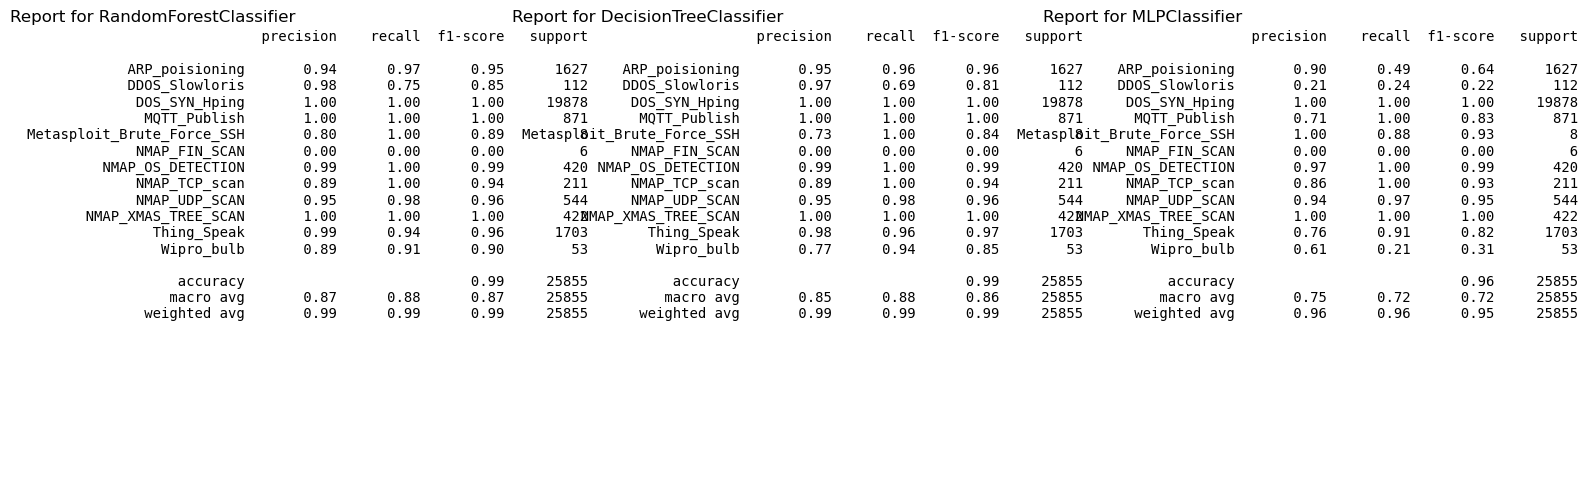

In [561]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, report in enumerate(classification_reports):
    axs[i].text(0.01, 1, report, {'fontsize': 10}, fontfamily='monospace', verticalalignment='top', horizontalalignment='left')
    axs[i].axis('off')
    axs[i].set_title(f"Report for {top_3_algorithms[i]}")

plt.tight_layout()
plt.show()

In [592]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings

def print_report(results,suppress_warnings=True):
    """
    Shows the top 3 performing algorithms and their classification reports
    
    Parameters:
    -----------
    - results: DataFrame
        A DataFrame containing the cv_results_ of a grid search
    - suppress_warnings: Boolean, default=True
        Whether to suppress warnings or show them.
    
    Returns:
    --------
    - None
    """
    
    # Suppress warnings
    if suppress_warnings:
        warnings.filterwarnings('ignore')
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    
    # Sort by test score
    sorted_results_df = results.sort_values('mean_test_score', ascending=False)

    # Calculate the top 30% cutoff
    cutoff_index = int(len(sorted_results_df) * 0.3)
    top_30_df = sorted_results_df.head(cutoff_index)
    
    # Extract algorithm names assuming param_clf is directly usable or adjust accordingly
    top_30_df['algorithm_name'] = top_30_df['param_clf'].copy().apply(lambda x: type(x).__name__)
    top_3_algorithms = top_30_df['algorithm_name'].value_counts().nlargest(3).index.tolist()
    print("Top 3 Algorithms:", top_3_algorithms)
    
    classification_reports = []
    for algo in top_3_algorithms:
        # Filter the DataFrame for this specific algorithm
        algo_df = top_30_df[top_30_df['algorithm_name'] == algo]

        # Get the best set of parameters for this algorithm
        best_params = algo_df.iloc[0]['params']

        # Set up the estimator with the best parameters
        estimator = gscv.estimator.set_params(**best_params)

        # Fit the estimator on the full dataset (or a training subset if specified)
        estimator.fit(X_set[0], y_set[0])

        # Optionally, evaluate on a test set and generate classification reports
        y_pred = estimator.predict(X_set[1])
        report = classification_report(y_set[1], y_pred)
        classification_reports.append(report)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, report in enumerate(classification_reports):
        axs[i].text(0.01, 1, report, {'fontsize': 10}, fontfamily='monospace', verticalalignment='top', horizontalalignment='left')
        axs[i].axis('off')
        axs[i].set_title(f"Report for {top_3_algorithms[i]}")

    plt.tight_layout()
    plt.show()
    
    return None

Top 3 Algorithms: ['RandomForestClassifier', 'DecisionTreeClassifier', 'MLPClassifier']


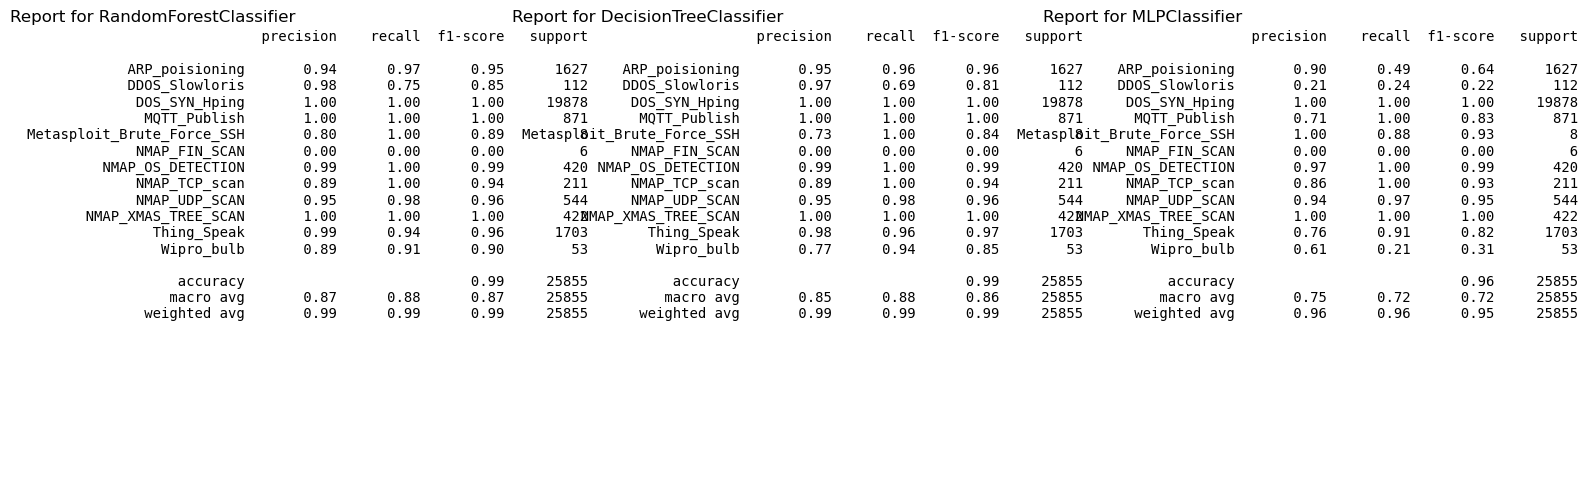

In [595]:
print_report(results)

In [613]:
search_space = [
    {
        'clf':[MLPClassifier(random_state=42)],
        'clf__hidden_layer_sizes':[(75,),(100,),(125,)],
        'clf__alpha':np.logspace(-4,2,20),
        'clf__learning_rate':['constant','invscaling','adaptive']
    },
    {
        'clf':[RandomForestClassifier(random_state=42)],
        'clf__n_estimators':[75,100,125],
        'clf__max_depth':[3,6,9,12,15],
        'clf__class_weight':['balanced','balanced_subsample']
    },
    {
        'kbest__k':[40,50,60,'all']
    }
]

In [615]:
finalist_pipeline = Pipeline(
    [
        ('scalar',RobustScaler()),
        ('kbest',fselect.SelectKBest()),
        ('clf',MLPClassifier())
    ]
)
finalist_pipeline

Pipeline(steps=[('scalar', RobustScaler()), ('kbest', SelectKBest()),
                ('clf', MLPClassifier())])

In [617]:
gscv = GridSearchCV(finalist_pipeline,search_space,cv=5,scoring='accuracy',verbose=1)


In [619]:
gscv.fit(X_set[0],y_set[0])

Fitting 5 folds for each of 214 candidates, totalling 1070 fits



KeyboardInterrupt



In [645]:
import time
# Warning handling
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

def final_models(X_train,y_train,suppress_warnings=True):
    """
    Return results of the top performing models using a grid search and pre-defined parameters.
    
    Parameters:
    -----------
    - X_train: DataFrame
        The dataset to be trained on
    - y_train: Series
        The target variable
    - suppress_warnings: Boolean, default=True
    
    Returns:
    --------
    DataFrame containing the results of the grid search.
    """
    
    start_time = time.time()
    
    # handle warnings
    if suppress_warnings:
        print('WARNINGS SUPRESSED.')
        
        # suppress divide by zero and other runtime warnings
        warnings.filterwarnings('ignore',category=RuntimeWarning)
        
        # suppress convergence warnings
        warnings.filterwarnings('ignore',category=ConvergenceWarning)
    
    print('Building search space...')
    search_space = [
        {
            'clf':[MLPClassifier(random_state=42)],
            'clf__hidden_layer_sizes':[(75,),(100,),(125,)],
            'clf__alpha':np.logspace(-4,2,20),
            'clf__learning_rate':['constant','invscaling','adaptive']
        },
        {
            'clf':[RandomForestClassifier(random_state=42)],
            'clf__n_estimators':[75,100,125],
            'clf__max_depth':[3,6,9,12,15],
            'clf__class_weight':['balanced','balanced_subsample']
        },
        {
            'kbest__k':[40,50,60,'all']
        }
    ]
    
    print('Building pipeline...')
    finalist_pipeline = Pipeline(
        [
            ('scalar',RobustScaler()),
            ('kbest',fselect.SelectKBest()),
            ('clf',MLPClassifier())
        ]
    )
    
    print('Building grid search...')
    gscv = GridSearchCV(finalist_pipeline,search_space,cv=5,scoring='accuracy',verbose=1)

    print('Fitting models...')
    gscv.fit(X_train,y_train)
    
    print(f'Models fitted. Elapsed time:{time.time() - start_time}')
    
    return pd.DataFrame(gscv.cv_results_)

In [649]:
results = final_models(X_set[0],y_set[0])

WARNINGS SUPRESSED.
Building search space...
Building pipeline...
Building grid search...
Fitting models...
Fitting 5 folds for each of 214 candidates, totalling 1070 fits
Models fitted. Elapsed time:5000.577212095261


In [695]:
results.param_kbest__k.value_counts(dropna=False)

param_kbest__k
NaN    210
40       1
50       1
60       1
all      1
Name: count, dtype: int64

In [675]:
final_model = results.sort_values('rank_test_score').iloc[0,4]

In [679]:
final_model.fit(X_set[0],y_set[0])

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=125,
                       random_state=42)

In [681]:
print(classification_report(y_set[1],final_model.predict(X_set[1])))

                            precision    recall  f1-score   support

            ARP_poisioning       0.99      0.99      0.99      1627
            DDOS_Slowloris       1.00      0.96      0.98       112
             DOS_SYN_Hping       1.00      1.00      1.00     19878
              MQTT_Publish       1.00      1.00      1.00       871
Metasploit_Brute_Force_SSH       0.89      1.00      0.94         8
             NMAP_FIN_SCAN       0.75      1.00      0.86         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       420
             NMAP_TCP_scan       1.00      1.00      1.00       211
             NMAP_UDP_SCAN       0.99      0.99      0.99       544
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       422
               Thing_Speak       0.99      0.99      0.99      1703
                Wipro_bulb       0.98      0.92      0.95        53

                  accuracy                           1.00     25855
                 macro avg       0.97      0.9